### **Introduction to Artificial Neural Networks with Keras** (Chapter 10)

https://github.com/ageron/handson-ml2

### <font color="blue">Setting up a virtual environement</font> 

Often times in Python (similar to R) the best way to sync the packages that one needs is to create a <font color='purple'>**new installation**</font>. On **Mac** and using **Anaconda**, the steps are

1) Create a **new environment** with the version of Python and the main packages you want, e.g.

<font color='darkpink'> conda create -n DSML_TF python=3.7 tensorflow numpy pandas scipy scikit-learn statsmodels matplotlib seaborn jupyterlab python-graphviz
 </font>

2) Then **activate** the environment DSML **before** starting your Jupyter Lab/Notebook 

<font color='darkpink'> conda activate DSML_TF </font>

Or if you need to install an additional package, before activate the environment, you might install *pydot*

<font color='darkpink'> conda install -c anaconda pydot </font>  

(_or perhaps_: <font color='darkpink'>conda install -c conda-forge pydot</font> )

3) When you are done deactivate the environment - only one is active at any point, so Anacond knows what to do:

<font color='darkpink'> conda deactivate </font>

In [1]:
%load_ext autoreload
%autoreload 2

#### Setup

Let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed, as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

In [3]:
## Scikit-Learn ≥0.20 is required - do NOT comment out, it's used in TF!!!
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

### --- To be able to use scikit-learn (SKL) for hyperparameter tunning, downgrade the SKL version 

Activate your environment and install an older version:

<font color='darkpink'> conda activate AML_TF

<font color='darkpink'> conda install scikit-learn==0.21.2  </font>

In [4]:
sklearn.__version__  # was: '0.23.2'

'1.0.1'

In [5]:
# Common imports
import numpy as np
import pandas as pd
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [6]:
# Tree plotting
import pydot
from IPython.display import Image
#import graphviz
from io import StringIO  

# Building an Image Classifier

First let's import TensorFlow and Keras.

In [7]:
import tensorflow as tf
from tensorflow import keras

In [8]:
tf.__version__
keras.__version__ #the error was because keras was not installed on my conda environment

'2.6.0'

Let's start by loading the fashion MNIST dataset. Keras has a number of functions to load popular datasets in `keras.datasets`. The dataset is **already split** for you between a **training** set and a **test** set, but it can be <font color='blue'>useful to split the training set further to have a validation set</font>:

In [9]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data() #returns numpy arrays

In [10]:
boston_housing = keras.datasets.boston_housing.load_data()
#boston_housing[:10:2]


The training set contains 60,000 grayscale images, each 28x28 pixels:

In [11]:
X_train_full.shape

(60000, 28, 28)

Each pixel intensity is represented as a byte (0 to 255):

In [12]:
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()
pd.set_option('display.max_columns', 100)
pd.DataFrame(X_train_full[0,:,:])

0    1    2    3    4    5    6    7    8    9    10   11   12   13   14  \
0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
1    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
2    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
3    0    0    0    0    0    0    0    0    0    0    0    0    1    0    0   
4    0    0    0    0    0    0    0    0    0    0    0    0    3    0   36   
5    0    0    0    0    0    0    0    0    0    0    0    0    6    0  102   
6    0    0    0    0    0    0    0    0    0    0    0    0    0    0  155   
7    0    0    0    0    0    0    0    0    0    0    0    1    0   69  207   
8    0    0    0    0    0    0    0    0    0    1    1    1    0  200  232   
9    0    0    0    0    0    0    0    0    0    0    0    0    0  183  225   
10   0    0    0    0    0    0    0    0    0    0    0    0    0  193  228   
11   0    0    0    0    0    0    0    0    0    1    3    0   12  219  220   
12   0    0    0    0    0    0    0    0    0    0    6    0   99  244  222   
13   0    0    0    0    0    0    0    0    0    4    0    0   55  236  228   
14   0    0    1    4    6    7    2    0    0    0    0    0  237  226  217   
15   0    3    0    0    0    0    0    0    0   62  145  204  228  207  213   
16   0    0    0    0   18   44   82  107  189  228  220  222  217  226  200   
17   0   57  187  208  224  221  224  208  204  214  208  209  200  159  245   
18   3  202  228  224  221  211  211  214  205  205  205  220  240   80  150   
19  98  233  198  210  222  229  229  234  249  220  194  215  217  241   65   
20  75  204  212  204  193  205  211  225  216  185  197  206  198  213  240   
21  48  203  183  194  213  197  185  190  194  192  202  214  219  221  220   
22   0  122  219  193  179  171  183  196  204  210  213  207  211  210  200   
23   0    0   74  189  212  191  175  172  175  181  185  188  189  188  193   
24   2    0    0    0   66  200  222  237  239  242  246  243  244  221  220   
25   0    0    0    0    0    0    0   40   61   44   72   41   35    0    0   
26   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
27   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   

     15   16   17   18   19   20   21   22   23   24   25   26   27  
0     0    0    0    0    0    0    0    0    0    0    0    0    0  
1     0    0    0    0    0    0    0    0    0    0    0    0    0  
2     0    0    0    0    0    0    0    0    0    0    0    0    0  
3    13   73    0    0    1    4    0    0    0    0    1    1    0  
4   136  127   62   54    0    0    0    1    3    4    0    0    3  
5   204  176  134  144  123   23    0    0    0    0   12   10    0  
6   236  207  178  107  156  161  109   64   23   77  130   72   15  
7   223  218  216  216  163  127  121  122  146  141   88  172   66  
8   232  233  229  223  223  215  213  164  127  123  196  229    0  
9   216  223  228  235  227  224  222  224  221  223  245  173    0  
10  218  213  198  180  212  210  211  213  223  220  243  202    0  
11  212  218  192  169  227  208  218  224  212  226  197  209   52  
12  220  218  203  198  221  215  213  222  220  245  119  167   56  
13  230  228  240  232  213  218  223  234  217  217  209   92    0  
14  223  222  219  222  221  216  223  229  215  218  255   77    0  
15  221  218  208  211  218  224  223  219  215  224  244  159    0  
16  205  211  230  224  234  176  188  250  248  233  238  215    0  
17  193  206  223  255  255  221  234  221  211  220  232  246    0  
18  255  229  221  188  154  191  210  204  209  222  228  225    0  
19   73  106  117  168  219  221  215  217  223  223  224  229   29  
20  195  227  245  239  223  218  212  209  222  220  221  230   67  
21  236  225  216  199  206  186  181  177  172  181  205  206  115  
22  196  194  191  195  191  198  192  176  156  167  177  210   92  
23 

In [13]:
# print(X_train_full[1,:,:]) # 1 image

#### Let's split the full training sets into validation sets and a (smaller) training set. We also scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255.

In [14]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

You can plot an image using Matplotlib's `imshow()` function, with a `'binary'`
 color map:

In [15]:
#X_train[0]

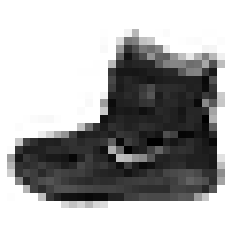

In [16]:
plt.imshow(X_valid[0], cmap="binary")
plt.axis('off')
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9. A uint8 data type contains all whole numbers from 0 to 255. As with all unsigned numbers, the values must be non-negative. Uint8's are mostly used in graphics (colors are always non-negative).|

In [17]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

Here are the corresponding 10 class names:

In [18]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

So the first image in the training set is a coat:

In [19]:
y_train[0] #returns 4
class_names #returns the list of class names
print(class_names[y_train[0]]) #return the fourth class name 4 ="Coat"

Coat


The validation set contains 5,000 images, and the test set contains 10,000 images:

In [20]:
X_valid.shape

(5000, 28, 28)

In [21]:
X_test.shape

(10000, 28, 28)

Let's take a look at a sample of the images in the dataset:

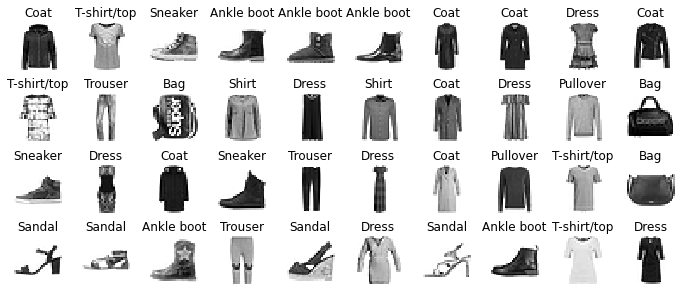

In [23]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
#save_fig('fashion_mnist_plot', tight_layout=False)
plt.show()

In [46]:
?plt.subplots_adjust

Signature:
plt.subplots_adjust(
    left=None,
    bottom=None,
    right=None,
    top=None,
    wspace=None,
    hspace=None,
)
Docstring:
Adjust the subplot layout parameters.

Unset parameters are left unmodified; initial values are given by
:rc:`figure.subplot.[name]`.

Parameters
----------
left : float, optional
    The position of the left edge of the subplots,
    as a fraction of the figure width.
right : float, optional
    The position of the right edge of the subplots,
    as a fraction of the figure width.
bottom : float, optional
    The position of the bottom edge of the subplots,
    as a fraction of the figure height.
top : float, optional
    The position of the top edge of the subplots,
    as a fraction of the figure height.
wspace : float, optional
    The width of the padding between subplots,
    as a fraction of the average Axes width.
hspace : float, optional
    The height of the padding between subplots,
    as a fraction of the average Axes height.
File:   

####  Start building the model

Use the Sequential API.simplest kind of Keras model for neural networks that are just composed of a **single stack of layers connected sequentially**. 

In [24]:
model = keras.models.Sequential()

model.add(keras.layers.Flatten(input_shape=[28, 28]))

model.add(keras.layers.Dense(300, activation="relu")) # hidden layer 1
model.add(keras.layers.Dense(100, activation="relu")) # hidden layer 2
model.add(keras.layers.Dense(10,  activation="softmax")) # max( output(i)/sum(output(j), j=0,1,...,9), i=0,...,9) => [0,1]

In [25]:
keras.layers.Dense(300, activation="relu")

In [26]:
### Reset session 
from tensorflow.keras.backend import clear_session
clear_session()
np.random.seed(555) #(42)
tf.random.set_seed(555) #(42)

In [27]:
### Another syntax for the same model 
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax") #10 is the number of classifications, softmax is the probability distribution
])

In [28]:
model.layers

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [32]:
###  A plot of the model structure
keras.utils.plot_model?

Signature:
keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
)
Docstring:
Converts a Keras model to dot format and save to a file.

Example:

```python
input = tf.keras.Input(shape=(100,), dtype='int32', name='input')
x = tf.keras.layers.Embedding(
    output_dim=512, input_dim=10000, input_length=100)(input)
x = tf.keras.layers.LSTM(32)(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
output = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(x)
model = tf.keras.Model(inputs=[input], outputs=[output])
dot_img_file = '/tmp/model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)
```

Args:
  model: A Keras model instance
  to_file: File name of the plot image.
  show_shapes: whethe

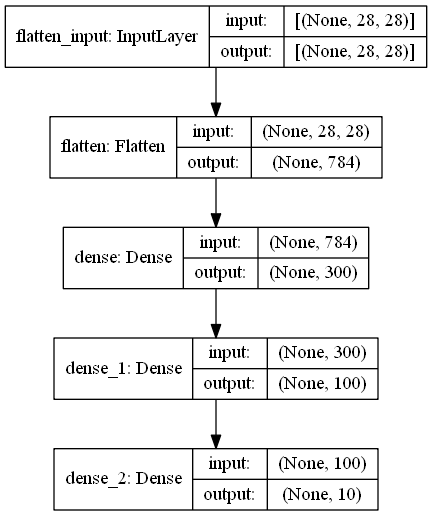

In [33]:
keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

In [35]:
print(model.layers[2])

In [36]:
hidden2 = model.layers[2]
hidden2.name

'dense_1'

In [37]:
# some more information available in 'model'
model.get_layer # Retrieves a layer based on either its name (unique) or index.
#If `name` and `index` are both provided, `index` will take precedence. 
# Indices are based on order of horizontal graph traversal (bottom-up).

Signature: model.get_layer(name=None, index=None)
Docstring:
Retrieves a layer based on either its name (unique) or index.

If `name` and `index` are both provided, `index` will take precedence.
Indices are based on order of horizontal graph traversal (bottom-up).

Args:
    name: String, name of layer.
    index: Integer, index of layer.

Returns:
    A layer instance.

Raises:
    ValueError: In case of invalid layer name or index.
File:      c:\users\daniel\anaconda3\envs\sfds\lib\site-packages\keras\engine\training.py
Type:      method


In [38]:
model.get_layer(hidden2.name) is hidden2

True

In [41]:
#hidden2.get_weights()
weights, biases = hidden2.get_weights()

In [42]:
weights

array([[ 0.06717192,  0.08789372,  0.03595584, ...,  0.08240473,
         0.10832307, -0.09728754],
       [ 0.02142016,  0.00534778,  0.0660788 , ..., -0.05591282,
        -0.06760298, -0.09108049],
       [-0.08921246, -0.02378049,  0.02145841, ...,  0.06382158,
        -0.01219756,  0.03477574],
       ...,
       [ 0.02474492,  0.07730637, -0.03976243, ..., -0.11225883,
         0.10993659, -0.06591722],
       [ 0.0917478 , -0.09542862, -0.07711543, ..., -0.09255559,
        -0.08973876, -0.08943006],
       [-0.11397051, -0.10458469,  0.02305057, ...,  0.00968454,
         0.08377012,  0.01591364]], dtype=float32)

In [43]:
weights.shape

(300, 100)

In [44]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [45]:
biases.shape

(100,)

In [46]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="SGD", #  optimizer="adam", this 
              metrics=["accuracy"])

This is equivalent to:

```python
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.SGD(),
              metrics=[keras.metrics.sparse_categorical_accuracy])
```

In [47]:
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_valid, y_valid)) # epochs=30

Epoch 1/5
1719/1719 [==============================] - 2s 885us/step - loss: 0.7060 - accuracy: 0.7669 - val_loss: 0.4919 - val_accuracy: 0.8306
Epoch 2/5
1719/1719 [==============================] - 1s 732us/step - loss: 0.4846 - accuracy: 0.8313 - val_loss: 0.4391 - val_accuracy: 0.8492
Epoch 3/5
1719/1719 [==============================] - 1s 730us/step - loss: 0.4400 - accuracy: 0.8446 - val_loss: 0.4250 - val_accuracy: 0.8486
Epoch 4/5
1719/1719 [==============================] - 1s 727us/step - loss: 0.4144 - accuracy: 0.8550 - val_loss: 0.3991 - val_accuracy: 0.8634
Epoch 5/5
1719/1719 [==============================] - 1s 756us/step - loss: 0.3945 - accuracy: 0.8611 - val_loss: 0.3961 - val_accuracy: 0.8620


In [48]:
history.params

{'verbose': 1, 'epochs': 5, 'steps': 1719}

In [50]:
print(history.epoch)
print(history.history.keys())

[0, 1, 2, 3, 4]
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [54]:
val_loss, val_acc = model.evaluate(X_test, y_test)
print(val_loss)
print(val_acc)
#print(history.val_loss) does not work as history does not hold the attribute of 'val_loss'

313/313 [==============================] - 0s 523us/step - loss: 0.4277 - accuracy: 0.8488
0.42772606015205383
0.848800003528595


In [57]:
import numpy as np
predictions = model.predict([X_test]) #returns 1 -hot arrays, they are probability distributions
print(np.argmax(predictions[0])) # the prediction for the 0th index is 9, the ankle boot

9


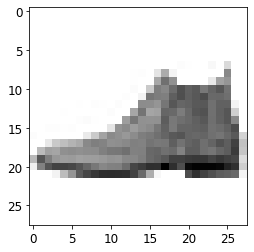

In [59]:
plt.imshow(X_test[0], cmap = 'binary')
plt.show()

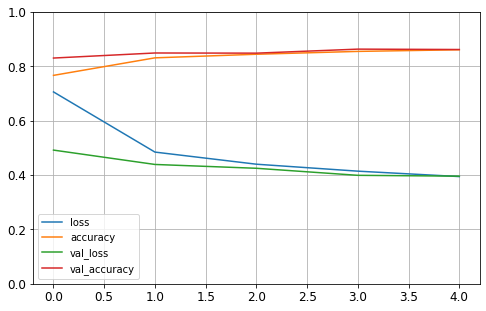

In [60]:
# import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
#save_fig("keras_learning_curves_plot")
plt.show()

In [48]:
model.evaluate(X_test, y_test, verbose=0) # [0.33780701770782473, 0.8781]

[0.3421731696128845, 0.8769]

In [49]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.05, 0.  , 0.94],
       [0.  , 0.  , 0.99, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [50]:
y_pred = model.predict_classes(X_new)
y_pred

array([9, 2, 1])

In [51]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [52]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

Saving figure fashion_mnist_images_plot


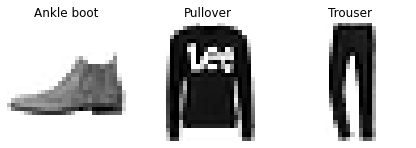

In [53]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_images_plot', tight_layout=False)
plt.show()

# Regression MLP

Let's load, split and scale the Boston house prices data https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html#sklearn.datasets.load_boston

California housing dataset (the original one, not the modified one as in chapter 2) wouldn't load for me. But you can get a copy here:

https://github.com/ageron/handson-ml2/tree/master/datasets/housing


Specifically, it contains:

median house value, median income, housing median age, total rooms, total bedrooms, population, households, latitude, longitude  - in that (?) order.

In [54]:
# fetch_california_housing?

In [55]:
from sklearn.datasets import fetch_california_housing, load_boston
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#housing = fetch_california_housing()
#housing = load_boston()

In [56]:
# Download the dataset as explained in HOML, Chap2 "End-to-end Machine Learning Project"

In [57]:
import os
import tarfile
import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)    

In [58]:
# download data
fetch_housing_data()

In [59]:
# get the data as a dataframe
housing = load_housing_data()
housing.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

In [60]:
# There are some missing values - only 207
housing.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [61]:
# Let's remove them. For other appoaches, consult Chap2 "End-to-end Machine Learning Project" (p.62)
housing = housing.dropna(subset=["total_bedrooms"])
#housing = housing[~housing.total_bedrooms.isna()]

In [62]:
housing.shape

(20433, 10)

In [63]:
housing.isna().sum() # ok now

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

#### Quick look at the data

In [64]:
# housing.info()
# housing.describe()

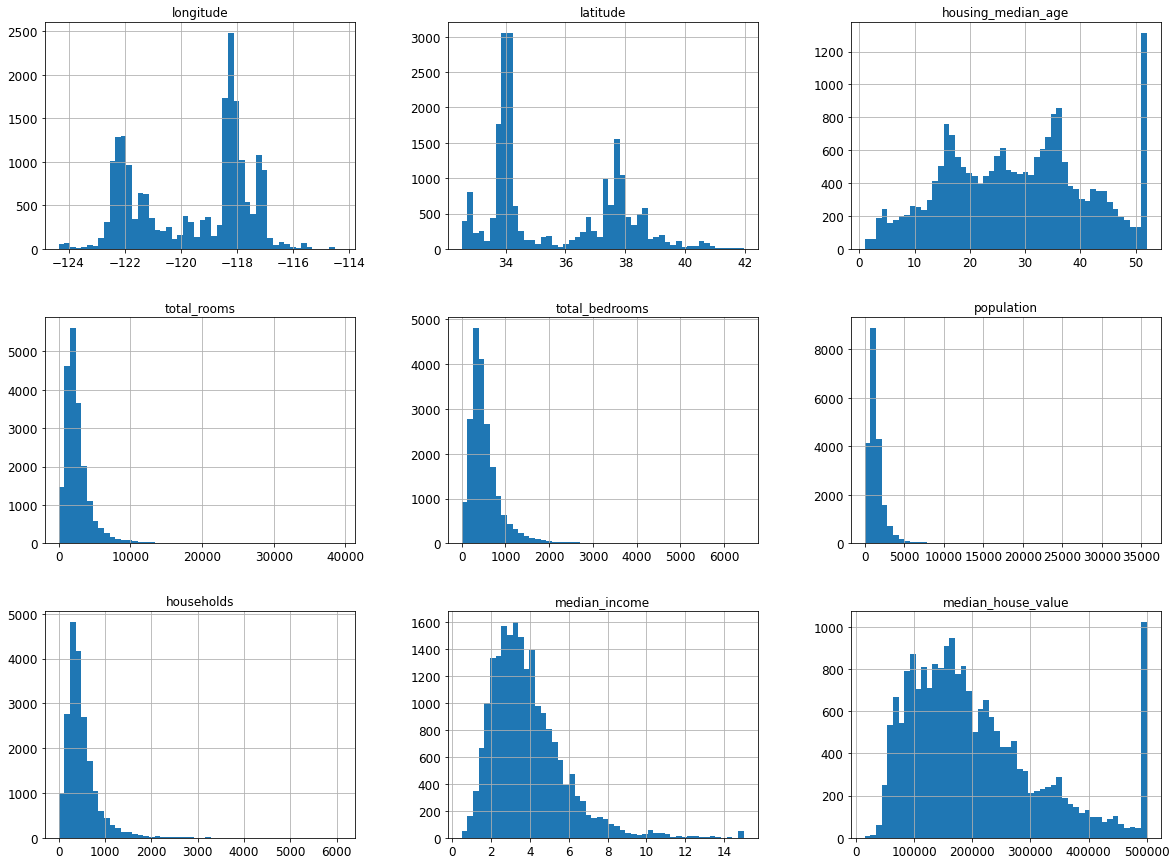

In [65]:
# housing.corr()
housing.hist(bins=50, figsize=(20,15)) 
plt.show()

In [66]:
# X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
h_data = housing.iloc[:,:8].to_numpy()
h_target = housing.iloc[:,8].to_numpy()

X_train_full, X_test, y_train_full, y_test = train_test_split(h_data, h_target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [67]:
### Build a simple linear regression as a base model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [68]:
housing_predictions = lin_reg.predict(X_train)
lin_mse = mean_squared_error(y_train, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

69751.51139459194

#### Now, build a NN 

In [192]:
#keras.backend.clear_session()
clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [193]:
# NOTE that the 'relu' activation is not working here
model= keras.models.Sequential([
    #keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:], kernel_initializer="he_normal"),
    keras.layers.Dense(30, activation="sigmoid",kernel_initializer="glorot_normal"),
    keras.layers.Dense(1)
])
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=1e-3)) #,clipvalue=1.0))
#model.compile(loss="mean_squared_error", optimizer=keras.optimizers.Adam(lr=1e-3))
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid)) # 20

Train on 11493 samples, validate on 3831 samples
Epoch 1/20
11493/11493 [==============================] - 1s 99us/sample - loss: 14111177850.3757 - val_loss: 9344009168.0209
Epoch 2/20
11493/11493 [==============================] - 1s 58us/sample - loss: 8498086749.7976 - val_loss: 8050831922.9862
Epoch 3/20
11493/11493 [==============================] - 1s 61us/sample - loss: 7579539375.4557 - val_loss: 7673472497.6998
Epoch 4/20
11493/11493 [==============================] - 1s 63us/sample - loss: 7302661601.8850 - val_loss: 7264859776.4344
Epoch 5/20
11493/11493 [==============================] - 1s 59us/sample - loss: 7102095232.8576 - val_loss: 7184666886.0809
Epoch 6/20
11493/11493 [==============================] - 1s 58us/sample - loss: 7128760486.4345 - val_loss: 7183375277.9410
Epoch 7/20
11493/11493 [==============================] - 1s 62us/sample - loss: 6965208325.5463 - val_loss: 7070665140.6233
Epoch 8/20
11493/11493 [==============================] - 1s 60us/sample - 

In [194]:
mse_test = model.evaluate(X_test, y_test, verbose = 0)
mse_test

6995663609.435898

In [195]:
# Root Mean Squared Error (RMSE)
np.sqrt(mse_test)

83640.08374837927

In [196]:
X_new = X_test[:3]
y_pred = model.predict(X_new)

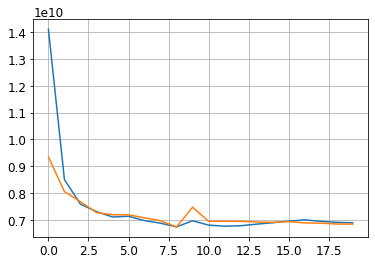

In [197]:
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
#plt.gca().set_ylim(0, 1)
plt.gca()
plt.show()

In [198]:
y_pred

array([[157315.89],
       [244981.61],
       [189446.92]], dtype=float32)

# Functional API

Not all neural network models are simply sequential. Some may have complex topologies. Some may have multiple inputs and/or multiple outputs. For example, a Wide & Deep neural network (see [paper](https://ai.google/research/pubs/pub45413)) connects all or part of the inputs directly to the output layer.

In [199]:
np.random.seed(42)
tf.random.set_seed(42)

In [203]:
input_ = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation="tanh")(input_)  # 'relu' activaton??
hidden2 = keras.layers.Dense(30, activation="tanh")(hidden1)
concat = keras.layers.concatenate([input_, hidden2])
output = keras.layers.Dense(1)(concat)
model = keras.models.Model(inputs=[input_], outputs=[output])

In [204]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 30)           270         input_2[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 30)           930         dense_5[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 38)           0           input_2[0][0]                    
                                                                 dense_6[0][0]              

In [205]:
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
y_pred = model.predict(X_new)

Train on 11493 samples, validate on 3831 samples
Epoch 1/20
11493/11493 [==============================] - 2s 147us/sample - loss: 18336010823.9464 - val_loss: 20314245512.9209
Epoch 2/20
11493/11493 [==============================] - 1s 72us/sample - loss: 14104845588.0693 - val_loss: 10108379972.6275
Epoch 3/20
11493/11493 [==============================] - 1s 71us/sample - loss: 9034453776.3272 - val_loss: 8632115634.1509
Epoch 4/20
11493/11493 [==============================] - 1s 71us/sample - loss: 8105456997.1705 - val_loss: 7564929773.2227
Epoch 5/20
11493/11493 [==============================] - 1s 72us/sample - loss: 7368748922.9771 - val_loss: 7038944735.8580
Epoch 6/20
11493/11493 [==============================] - 1s 71us/sample - loss: 6896027806.8612 - val_loss: 6633654947.5166
Epoch 7/20
11493/11493 [==============================] - 1s 72us/sample - loss: 6544723388.4639 - val_loss: 6347127553.2028
Epoch 8/20
11493/11493 [==============================] - 1s 72us/sampl

What if you want to send different subsets of input features through the wide or deep paths? 

We will send 5 features (features 0 to 4), and 6 (features 2 to 7) through the **deep path**. Note that 3 features will go through both (features 2, 3 and 4).

In [206]:
np.random.seed(42)
tf.random.set_seed(42)

In [207]:
X_train.shape

(11493, 8)

In [211]:
input_A = keras.layers.Input(shape=[5], name="wide_input")  # shape=[10]
input_B = keras.layers.Input(shape=[6], name="deep_input")  # shape=[11]
hidden1 = keras.layers.Dense(30, activation="tanh")(input_B)
hidden2 = keras.layers.Dense(30, activation="tanh")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="output")(concat)
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

In [212]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]  # X_train[:, :10], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]  # X_valid[:, :10], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]      # X_test[:, :10], X_test[:, 2:] 
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

history = model.fit((X_train_A, X_train_B), y_train, epochs=20,
                    validation_data=((X_valid_A, X_valid_B), y_valid))
mse_test = model.evaluate((X_test_A, X_test_B), y_test)
y_pred = model.predict((X_new_A, X_new_B))

Train on 11493 samples, validate on 3831 samples
Epoch 1/20
11493/11493 [==============================] - 2s 142us/sample - loss: 16030786697.5223 - val_loss: 11177908930.3221
Epoch 2/20
11493/11493 [==============================] - 1s 76us/sample - loss: 9652848805.6326 - val_loss: 9345387316.7236
Epoch 3/20
11493/11493 [==============================] - 1s 81us/sample - loss: 8654339528.6258 - val_loss: 8768051617.7792
Epoch 4/20
11493/11493 [==============================] - 1s 78us/sample - loss: 8265261860.5523 - val_loss: 8435722470.8076
Epoch 5/20
11493/11493 [==============================] - 1s 74us/sample - loss: 8020860669.7948 - val_loss: 8184942723.2409
Epoch 6/20
11493/11493 [==============================] - 1s 74us/sample - loss: 7835792521.1214 - val_loss: 7984922653.2686
Epoch 7/20
11493/11493 [==============================] - 1s 73us/sample - loss: 7679942624.1030 - val_loss: 7834099704.6494
Epoch 8/20
11493/11493 [==============================] - 1s 79us/sample 

Adding an auxiliary output for regularization:

In [213]:
np.random.seed(42)
tf.random.set_seed(42)

In [215]:
input_A = keras.layers.Input(shape=[5], name="wide_input") # shape=[10]
input_B = keras.layers.Input(shape=[6], name="deep_input") # shape=[11]
hidden1 = keras.layers.Dense(30, activation="tanh")(input_B) # relu
hidden2 = keras.layers.Dense(30, activation="tanh")(hidden1) # relu
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="main_output")(concat)
aux_output = keras.layers.Dense(1, name="aux_output")(hidden2)
model = keras.models.Model(inputs=[input_A, input_B],
                           outputs=[output, aux_output])

In [216]:
model.compile(loss=["mse", "mse"], loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(lr=1e-3))

In [217]:
history = model.fit([X_train_A, X_train_B], [y_train, y_train], epochs=20,
                    validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid]))

Train on 11493 samples, validate on 3831 samples
Epoch 1/20
11493/11493 [==============================] - 2s 168us/sample - loss: 20806432318.0566 - main_output_loss: 19522256896.0000 - aux_output_loss: 32308805632.0000 - val_loss: 17782547702.4443 - val_main_output_loss: 16536252416.0000 - val_aux_output_loss: 28831535104.0000
Epoch 2/20
11493/11493 [==============================] - 1s 94us/sample - loss: 14432596741.1008 - main_output_loss: 13125118976.0000 - aux_output_loss: 26017038336.0000 - val_loss: 12710474067.4623 - val_main_output_loss: 11439432704.0000 - val_aux_output_loss: 24020727808.0000
Epoch 3/20
11493/11493 [==============================] - 1s 90us/sample - loss: 12081369021.1767 - main_output_loss: 11015150592.0000 - aux_output_loss: 21846061056.0000 - val_loss: 11738848887.8810 - val_main_output_loss: 10755084288.0000 - val_aux_output_loss: 20464685056.0000
Epoch 4/20
11493/11493 [==============================] - 1s 84us/sample - loss: 11588115037.7531 - main_ou

In [218]:
total_loss, main_loss, aux_loss = model.evaluate(
    [X_test_A, X_test_B], [y_test, y_test])
y_pred_main, y_pred_aux = model.predict([X_new_A, X_new_B])

5109/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [222]:
# 5160/5160 [==============================] - 0s 19us/sample - loss: 0.4656 - main_output_loss: 0.4165 - aux_output_loss: 0.9111

# Saving and Restoring

In [219]:
np.random.seed(42)
tf.random.set_seed(42)

In [220]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]), # input_shape=[13]
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    

In [221]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)

Train on 11493 samples, validate on 3831 samples
Epoch 1/10
11493/11493 [==============================] - 1s 113us/sample - loss: 626816513785362251776.0000 - val_loss: 16551594137911338.0000
Epoch 2/10
11493/11493 [==============================] - 1s 67us/sample - loss: 8795003189882093.0000 - val_loss: 3915909702444999.0000
Epoch 3/10
11493/11493 [==============================] - 1s 65us/sample - loss: 2080802466676515.2500 - val_loss: 926468119270976.3750
Epoch 4/10
11493/11493 [==============================] - 1s 65us/sample - loss: 492302799378740.1250 - val_loss: 219199687073665.8438
Epoch 5/10
11493/11493 [==============================] - 1s 65us/sample - loss: 116483008079625.2031 - val_loss: 51871777814454.7578
Epoch 6/10
11493/11493 [==============================] - 1s 66us/sample - loss: 27568729912446.7852 - val_loss: 12282937486567.7422
Epoch 7/10
11493/11493 [==============================] - 1s 70us/sample - loss: 6533388304053.2695 - val_loss: 2915936512092.4834
E

In [223]:
model.save("my_keras_model.h5")

In [224]:
model = keras.models.load_model("my_keras_model.h5")

In [225]:
model.predict(X_new)

array([[403005.62],
       [403005.62],
       [403005.62]], dtype=float32)

In [226]:
model.save_weights("my_keras_weights.ckpt")

In [227]:
model.load_weights("my_keras_weights.ckpt")

# Using Callbacks during Training

In [228]:
clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [233]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="tanh", input_shape=[8]), # input_shape=[13]
    keras.layers.Dense(30, activation="tanh"),
    keras.layers.Dense(1)
])    

In [234]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb])
model = keras.models.load_model("my_keras_model.h5") # rollback to best model
mse_test = model.evaluate(X_test, y_test)

Train on 11493 samples, validate on 3831 samples
Epoch 1/10
11493/11493 [==============================] - 1s 119us/sample - loss: 17585348814.7067 - val_loss: 13705295228.0908
Epoch 2/10
11493/11493 [==============================] - 1s 64us/sample - loss: 12407689373.8811 - val_loss: 11447739660.8969
Epoch 3/10
11493/11493 [==============================] - 1s 69us/sample - loss: 10994957986.8261 - val_loss: 10660475855.6199
Epoch 4/10
11493/11493 [==============================] - 1s 69us/sample - loss: 10517367830.9872 - val_loss: 10304852824.9418
Epoch 5/10
11493/11493 [==============================] - 1s 63us/sample - loss: 10295318522.3868 - val_loss: 10096587638.7450
Epoch 6/10
11493/11493 [==============================] - 1s 64us/sample - loss: 10160253467.7539 - val_loss: 9971496620.4041
Epoch 7/10
11493/11493 [==============================] - 1s 66us/sample - loss: 10068222220.0059 - val_loss: 9888573817.5516
Epoch 8/10
11493/11493 [==============================] - 1s 64

In [235]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb])
mse_test = model.evaluate(X_test, y_test)

Train on 11493 samples, validate on 3831 samples
Epoch 1/100
11493/11493 [==============================] - 1s 109us/sample - loss: 9897264677.9111 - val_loss: 9693210540.3372
Epoch 2/100
11493/11493 [==============================] - 1s 65us/sample - loss: 9873882749.4496 - val_loss: 9668952308.8405
Epoch 3/100
11493/11493 [==============================] - 1s 67us/sample - loss: 9848797966.9016 - val_loss: 9678079405.2728
Epoch 4/100
11493/11493 [==============================] - 1s 69us/sample - loss: 9839494082.8121 - val_loss: 9645864817.1318
Epoch 5/100
11493/11493 [==============================] - 1s 65us/sample - loss: 9828531138.2553 - val_loss: 9616965526.5529
Epoch 6/100
11493/11493 [==============================] - 1s 64us/sample - loss: 9815606052.0177 - val_loss: 9606550979.7254
Epoch 7/100
11493/11493 [==============================] - 1s 65us/sample - loss: 9803230585.8634 - val_loss: 9598250540.3707
Epoch 8/100
11493/11493 [==============================] - 1s 65us/s

In [236]:
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print("\nval/train: {:.2f}".format(logs["val_loss"] / logs["loss"]))

In [237]:
val_train_ratio_cb = PrintValTrainRatioCallback()
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[val_train_ratio_cb])

Train on 11493 samples, validate on 3831 samples
10816/11493 [===========================>..] - ETA: 0s - loss: 9711312961.8935
val/train: 0.98
11493/11493 [==============================] - 1s 75us/sample - loss: 9757569475.6363 - val_loss: 9533318088.2694


# TensorBoard

In [238]:
root_logdir = os.path.join(os.curdir, "my_logs")

In [239]:
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
run_logdir

'./my_logs/run_2021_02_13-21_09_18'

In [254]:
# from tensorflow.keras.backend import clear_session
# keras.backend.clear_session()
clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [243]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="tanh", input_shape=[8]), # input_shape=[13]
    keras.layers.Dense(30, activation="tanh"),
    keras.layers.Dense(1)
])    
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

In [244]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb])

Train on 11493 samples, validate on 3831 samples
Epoch 1/30
11493/11493 [==============================] - 1s 109us/sample - loss: 23180567233.0302 - val_loss: 17990210804.5732
Epoch 2/30
11493/11493 [==============================] - 1s 64us/sample - loss: 16040174552.5297 - val_loss: 14988878666.7753
Epoch 3/30
11493/11493 [==============================] - 1s 64us/sample - loss: 14202511943.5900 - val_loss: 13913907625.2634
Epoch 4/30
11493/11493 [==============================] - 1s 65us/sample - loss: 13136668790.7895 - val_loss: 13001635327.0645
Epoch 5/30
11493/11493 [==============================] - 1s 65us/sample - loss: 12614638351.3471 - val_loss: 12639657161.5390
Epoch 6/30
11493/11493 [==============================] - 1s 62us/sample - loss: 12347574586.8713 - val_loss: 12401650195.1115
Epoch 7/30
11493/11493 [==============================] - 1s 64us/sample - loss: 12166866862.1192 - val_loss: 12253931388.7591
Epoch 8/30
11493/11493 [==============================] - 1s 

**Before** you start TensorBoard (TB) you might want to free port 6006 (the port where you usually run the TB server):

In [265]:
# To free the 6006 port run (in the termnal):

!lsof -i tcp:6006 | grep -v PID | awk '{print $2}' | xargs kill

### fuser 6006/tcp -k

And also clean-up some of the old logs:

! rm -rf ./my_logs/run_2021_02_01-00_11_52/

You can also delete these not needed log directories directly from the "File Browser" in Jupyter Lab.

**To start** the TensorBoard server, one option is to open a terminal, if needed activate the virtualenv where you installed TensorBoard, go to this notebook's directory, then type:

```bash
$ tensorboard --logdir=./my_logs --port=6006
```

You can then open your web browser to [localhost:6006](http://localhost:6006) and use TensorBoard. Once you are done, press Ctrl-C in the terminal window, this will shutdown the TensorBoard server.

Alternatively, you can load TensorBoard's Jupyter extension and run it like this:

In [266]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [267]:
# Current log directory
run_logdir2 = get_run_logdir()
run_logdir2

'./my_logs/run_2021_02_13-22_55_05'

In [268]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="tanh", input_shape=[8]), #input_shape=[13]
    keras.layers.Dense(30, activation="tanh"),
    keras.layers.Dense(1)
])    
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3)) # 0.05

In [269]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir2)
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb])

Train on 11493 samples, validate on 3831 samples
Epoch 1/30
11493/11493 [==============================] - 1s 116us/sample - loss: 23180567233.0302 - val_loss: 17990210804.5732
Epoch 2/30
11493/11493 [==============================] - 1s 65us/sample - loss: 16040174552.5297 - val_loss: 14988878666.7753
Epoch 3/30
11493/11493 [==============================] - 1s 65us/sample - loss: 14202511943.5900 - val_loss: 13913907625.2634
Epoch 4/30
11493/11493 [==============================] - 1s 65us/sample - loss: 13136668790.7895 - val_loss: 13001635327.0645
Epoch 5/30
11493/11493 [==============================] - 1s 65us/sample - loss: 12614638351.3471 - val_loss: 12639657161.5390
Epoch 6/30
11493/11493 [==============================] - 1s 66us/sample - loss: 12347574586.8713 - val_loss: 12401650195.1115
Epoch 7/30
11493/11493 [==============================] - 1s 63us/sample - loss: 12166866862.1192 - val_loss: 12253931388.7591
Epoch 8/30
11493/11493 [==============================] - 1s 

Notice how TensorBoard now sees two runs, and you can compare the learning curves.

Check out the other available logging options:

In [270]:
help(keras.callbacks.TensorBoard.__init__)

Help on function __init__ in module tensorflow.python.keras.callbacks:

__init__(self, log_dir='logs', histogram_freq=0, write_graph=True, write_images=False, update_freq='epoch', profile_batch=2, embeddings_freq=0, embeddings_metadata=None, **kwargs)
    Initialize self.  See help(type(self)) for accurate signature.



In [271]:
### Additional capabilites of TensorBoard

In [272]:
test_logdir = get_run_logdir()
writer = tf.summary.create_file_writer(test_logdir) 
with writer.as_default():
    for step in range(1, 1000 + 1):
        tf.summary.scalar("my_scalar", np.sin(step / 10), step=step)
        data = (np.random.randn(100) + 2) * step / 100 # some random data 
        
        tf.summary.histogram("my_hist", data, buckets=50, step=step)
        
        images = np.random.rand(2, 32, 32, 3) # random 32×32 RGB images 
        tf.summary.image("my_images", images * step / 1000, step=step)
        
        texts = ["The step is " + str(step), "Its square is " + str(step**2)] 
        tf.summary.text("my_text", texts, step=step)
        
        sine_wave = tf.math.sin(tf.range(12000) / 48000 * 2 * np.pi * step) 
        audio = tf.reshape(tf.cast(sine_wave, tf.float32), [1, -1, 1]) 
        tf.summary.audio("my_audio", audio, sample_rate=48000, step=step)

### Fine-Tuning Neural Network Hyperparameters

The flexibility of neural networks is also one of their main drawbacks: there are many hyperparameters to tweak. 
Not only can you use any imaginable network architecture, but even in a simple MLP you can change the:

* number of layers

* number of neurons per layer

* activation function to use in each layer, the 

* weight initialization logic, etc. 

How do you know what combination of hyperparameters is the best for your task?

One option is to simply try many combinations of hyperparameters and see which one works best on the validation set (or use K-fold cross-validation). 
For example, we can use GridSearchCV or RandomizedSearchCV to explore the hyperparameter space, as is done in Chapter 2. 
To do this, we need to wrap our Keras models in objects that mimic regular Scikit-Learn regressors. The first step is to create a function that will build and compile 
a Keras model, given a set of hyperparameters:

In [306]:
clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [308]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[8]): # input_shape=[13]): 
    model = keras.models.Sequential() 
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="tanh"))  # was" 'relu'
        
    model.add(keras.layers.Dense(1))
    
    #optimizer = keras.optimizers.SGD(lr=learning_rate)
    # ask for Adam:
    optimizer = keras.optimizers.Adam(lr=learning_rate)
    
    model.compile(loss="mse", optimizer=optimizer)
    return model

We don’t want to train and evaluate a single model like this, though we want to train hundreds of variants and see which one performs best on the validation set. Since there are many hyperparameters, it is preferable to use a randomized search rather than grid search (as we discussed in Chapter 2). Let’s try to explore the number of hidden layers, the number of neurons, and the learning rate:

In [309]:
X_train.shape, X_valid.shape

((11493, 8), (3831, 8))

In [310]:
mod_test = build_model() 
mod_test.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                270       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________


In [311]:
### to measure run time
import time

#### **IMPORTANT**: the search below takes ~52 mins!

To reduce run time, you can reduce the number of parameter combination or use other methods described in Chapter 10. Specifically check out the "stretch pants" approach on p.325.

In [312]:
start = time.process_time()

In [313]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

# define a hyper-parameter grid
param_distribs = {
        "n_hidden": [0, 1, 2], # [0, 1, 2, 3],
        "n_neurons": np.arange(4,20),  # np.arange(1, 100), # tuple(),
        "learning_rate": reciprocal(3e-4, 3e-2) #[0.3] # 
}

keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3)

rnd_search_cv.fit(X_train, y_train, epochs=100
                  ,validation_data=(X_valid, y_valid)
                  ,callbacks=[keras.callbacks.EarlyStopping(patience=10)]
                  ,verbose=0)

3831/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0xa5646c3d0>,
                   iid='warn', n_iter=10, n_jobs=None,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0xa5646c390>,
                                        'n_hidden': [0, 1, 2],
                                        'n_neurons': array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=0)

In [314]:
print(f'Time: {(time.process_time()-start)/60} mins') # 12mins

Time: 52.78347933333334 mins


In [315]:
rnd_search_cv.cv_results_

{'mean_fit_time': array([45.81700953, 43.95219747, 50.23368367, 44.17348003, 50.41973003,
        47.14825638, 43.91981443, 47.50168188, 43.99069468, 48.49953373]),
 'std_fit_time': array([1.89594882, 0.09411809, 0.32343525, 0.04407148, 0.40218627,
        0.10851515, 0.11613255, 0.17937573, 0.08264854, 0.5935145 ]),
 'mean_score_time': array([0.14861242, 0.14364195, 0.14975444, 0.13839666, 0.15780767,
        0.14735699, 0.14502652, 0.15046581, 0.14030401, 0.14994884]),
 'std_score_time': array([0.01228833, 0.00578409, 0.00142813, 0.00130162, 0.0034602 ,
        0.00206501, 0.00400358, 0.00238034, 0.00099521, 0.00428556]),
 'param_learning_rate': masked_array(data=[0.001683454924600351, 0.008731907739399206,
                    0.0006154014789262348, 0.0003920021771415983,
                    0.0005792351260964139, 0.000388995352612812,
                    0.00030107783636342726, 0.0012178834831452913,
                    0.0021928619507738728, 0.005021425736625637],
              mas

In [316]:
rnd_search_cv.best_params_

{'learning_rate': 0.005021425736625637, 'n_hidden': 1, 'n_neurons': 19}

In [317]:
rnd_search_cv.best_score_

-55034606508.51544

In [318]:
model_b = rnd_search_cv.best_estimator_.model

In [319]:
model_b.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_53 (Dense)             (None, 19)                171       
_________________________________________________________________
dense_54 (Dense)             (None, 1)                 20        
Total params: 191
Trainable params: 191
Non-trainable params: 0
_________________________________________________________________
